In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

import sys
import sklearn


#!pip install gym[classic_control]
#!pip install gym[classic_control]
!pip install gymnasium[classic_control]
import gym
import tensorflow as tf
from tensorflow import keras

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# To get smooth animations
import matplotlib.animation as animation
mpl.rc('animation', html='jshtml')

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "rl"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 34.6 MB/s eta 0:00:0000:0100:01


#  Introducción a OpenAI gym

Se utilizará [OpenAI gymnasium](https://gymnasium.farama.org/), como paquete básico para la simulación de ambientes/entornes orientados al entrenameinto de algoritmos de Aprendizaje por Refuerzo.

In [2]:
gym.envs.registry.keys()

dict_keys(['CartPole-v0', 'CartPole-v1', 'MountainCar-v0', 'MountainCarContinuous-v0', 'Pendulum-v1', 'Acrobot-v1', 'LunarLander-v2', 'LunarLanderContinuous-v2', 'BipedalWalker-v3', 'BipedalWalkerHardcore-v3', 'CarRacing-v2', 'Blackjack-v1', 'FrozenLake-v1', 'FrozenLake8x8-v1', 'CliffWalking-v0', 'Taxi-v3', 'Reacher-v2', 'Reacher-v4', 'Pusher-v2', 'Pusher-v4', 'InvertedPendulum-v2', 'InvertedPendulum-v4', 'InvertedDoublePendulum-v2', 'InvertedDoublePendulum-v4', 'HalfCheetah-v2', 'HalfCheetah-v3', 'HalfCheetah-v4', 'Hopper-v2', 'Hopper-v3', 'Hopper-v4', 'Swimmer-v2', 'Swimmer-v3', 'Swimmer-v4', 'Walker2d-v2', 'Walker2d-v3', 'Walker2d-v4', 'Ant-v2', 'Ant-v3', 'Ant-v4', 'Humanoid-v2', 'Humanoid-v3', 'Humanoid-v4', 'HumanoidStandup-v2', 'HumanoidStandup-v4'])

- El [Cart-Pole V1](https://gymnasium.farama.org/environments/classic_control/cart_pole/) es un escenario de simulación simple que permite movilizar a izquierda a derecha un carro con mastil.

- El agente debe mover el carro con el fin de mantener el mastil en vertical.

In [3]:
env = gym.make('CartPole-v1',render_mode="rgb_array") #creamos el ambiente cartpole

Se inicializa el escenario:

In [4]:
obs = env.reset(seed=42)#retorna una observación

- La observación varia según el escenario.
- En este caso es un numpy array con cuatro floats: posición horizontal, velocidad, ángulo del mastil (0 = vertical), y velocidad angular.

In [5]:
print(obs)

(array([ 0.0273956 , -0.00611216,  0.03585979,  0.0197368 ], dtype=float32), {})


-Un escenario puede ser vizualizado mediante el método `render()`.

**Warning**: algunos escanrios acceden a la pantalla para realizar el render, generando una nueva ventana. Para evitar problemas con el manejo de la pantalla en Jupyter o .ipynb se instala un servidor falso [Xvfb](http://en.wikipedia.org/wiki/Xvfb). 

In [6]:
!pip install pyvirtualdisplay

In [7]:
import pyvirtualdisplay
display = pyvirtualdisplay.Display(visible=0, size=(1400, 900)).start()
display

In [8]:
env.render() # metodo render

array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]

Se activa el `mode="rgb_array"` para obtener una imagen del escenario como array de numpy:

In [9]:
img = env.render()
img.shape

(400, 600, 3)

Se crea una función para graficar cada estado de la simulación

In [10]:
def plot_environment(env, figsize=(5,4)):#funcion para graficar escenario como imagen rgb
    plt.figure(figsize=figsize)
    img = env.render()
    plt.imshow(img)
    plt.axis("off")
    return img

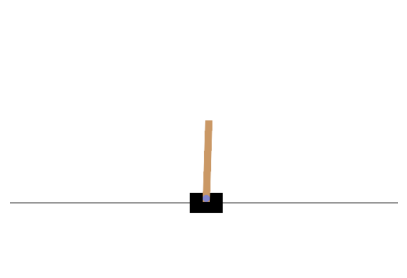

In [11]:
plot_environment(env)
plt.show()

- Cómo interactuar con el escenario?
-El agente debe escoger una acción del "action space"

In [12]:
env.action_space

Discrete(2)

Acciones disponibles: acelerar a izquierda o derecha

In [13]:
action = 1  # accelerate right
obs, reward, done, trun, info = env.step(action)
env.step?

Signature: env.step(action)
Docstring:
Steps through the environment and if the number of steps elapsed exceeds ``max_episode_steps`` then truncate.

Args:
    action: The environment step action

Returns:
    The environment step ``(observation, reward, terminated, truncated, info)`` with `truncated=True`
    if the number of steps elapsed >= max episode steps
File:      /opt/conda/lib/python3.10/site-packages/gym/wrappers/time_limit.py
Type:      method

Saving figure cart_pole_plot


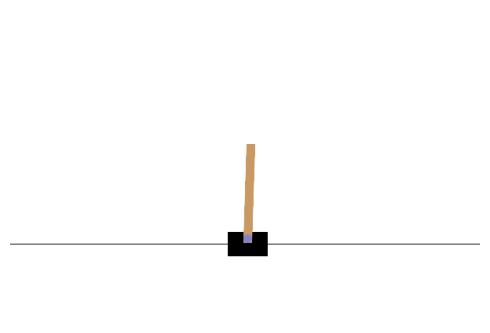

In [14]:
plot_environment(env)
save_fig("cart_pole_plot")

- La secuencia de pasos en el escenario desde el reset hasta done=True se conoce como "episode". 
- Al final de un (i.e., cuando `step()` retorna `done=True`), se debe resetear el escenario.- La secuencia de pasos en el escenario desde el reset hasta done=True se conoce como "episode". 
- Al final de un (i.e., cuando `step()` retorna `done=True`), se debe resetear el escenario.

In [15]:
obs,_ = env.reset(seed=42)
obs

array([ 0.0273956 , -0.00611216,  0.03585979,  0.0197368 ], dtype=float32)

- Se necesita de una _policy_ para que el agente realice bien su trabajo. 

- Policy se refiere a la estrategia que seguira el agente para seleccionar una acción en cada paso.

- Puede tener en cuenta los pasos y acciones del pasado para decidir qué hacer!

# Policy simple

- Si el mastil se inclina a izquierda, empuja hacia la izquierda, y  _vice versa_. 

In [16]:
def basic_policy(obs):
    angle = obs[2]
    return 0 if angle < 0 else 1


totals = []
for episode in range(500):
    episode_rewards = 0
    obs,_ = env.reset()
    for step in range(200):
        action = basic_policy(obs)
        obs, reward, done, trun, info = env.step(action)
        episode_rewards += reward
        if done:
            break
    totals.append(episode_rewards)

#desempeños     
np.mean(totals), np.std(totals), np.min(totals), np.max(totals)

(42.18, 9.015963620157304, 24.0, 72.0)

- Logró mantenerse vertical por 42 pasos en promedio! 
- El escenario es considerado exitoso para esta tarea si logra mantenerse al menos para 200 pasos.

In [17]:
#render de la simulación
frames = []
obs,_ = env.reset()
for step in range(200):
    img = env.render()
    frames.append(img)
    action = basic_policy(obs)

    obs, reward, done, trun, info = env.step(action)
    if done:
        break

In [18]:
def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch

def plot_animation(frames, repeat=False, interval=40):
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    anim = animation.FuncAnimation(
        fig, update_scene, fargs=(frames, patch),
        frames=len(frames), repeat=repeat, interval=interval)
    plt.close()
    return anim

In [19]:
plot_animation(frames)

# Neural Network Policies

- Se creará una red neuronal que obtendrá las observaciones como entrada y
estimará en la salida las probabilidades de las acciones a tomar por cada entrada (observación).

- Para escoger una acción, la red estimará la probabilidad de cada acción, y seleccionará la acción de forma aleatoria con base a las probabilidades estimadas.

- Para este caso del Cart-Pole, hay solo dos posibles acciones (izquierda y derecha), por ende solo se requiere una neurona de salida.

- La neurona estimará la probabilidad `p` para la acción izquierda (0) y `1 - p` será derecha (1)

In [20]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

n_inputs = 4 # == env.observation_space.shape[0] #espacio de observaciones en cart-pole

model = keras.models.Sequential([
    keras.layers.Dense(5, activation="elu", input_shape=[n_inputs]),
    keras.layers.Dense(1, activation="sigmoid"),
])

- En este caso, las acciones del pasado se pueden ignorar dado que el espacio de observaciones contiene la información completa del estado del ambiente (estado completo).

- Si se necesitaran hidden states (estados ocultos) se requerirían acciones y observaciones del pasado para inferir dichos estados ocultos del escenario. 

- **Ejemplo**: si el ambiente solo revelara la posición de cart pero no su velocidad, debería considerarse observaciones previas para inferir dicha variable. (Si el ambiente fuera ruidoso seria conveniente tener información del pasado).

**NOTA:** Se escoge una acción con base a las probabilidades estimadas para que el agente encuentre un balance entre _exploring_ nuevas acciones y _exploiting_ las acciones que se saben son buenas.

## Modelo no entrenado - aleatorio

In [21]:
def render_policy_net(model, n_max_steps=200, seed=42): 
    frames = []
    env = gym.make('CartPole-v1',render_mode="rgb_array") 
    np.random.seed(seed)
    obs,_ = env.reset(seed=seed)
    for step in range(n_max_steps):
        frames.append(env.render())
        left_proba = model.predict(obs.reshape(1, -1))
        action = int(np.random.rand() > left_proba)
        obs, reward, done, trun, info = env.step(action)
        if done:
            break
    env.close()
    return frames

In [22]:
frames = render_policy_net(model)
plot_animation(frames)

1/1 [==============================] - 0s 22ms/step


- La red jugará en 50 diferentes escenarios en paralelo (ofrece una variedad de lotes de entrenamiento en cada paso), y se entrena para 5000 iteraciones.

- Se deben resetear los ambientes una vez se termine cada escenario (done True en el vector de observaciones).

- Se entrena el modelo con un lazo custom.

In [23]:
n_environments = 50
n_iterations = 5000

envs = [gym.make('CartPole-v1',render_mode="rgb_array") for _ in range(n_environments)] # crear lista de escenarios
for index, env in enumerate(envs):
    env.reset(seed=index)
np.random.seed(42)
observations = [env.reset(seed=index)[0] for env in envs]
optimizer = keras.optimizers.RMSprop()
loss_fn = keras.losses.binary_crossentropy #funcion de costo tipo clasificacion

for iteration in range(n_iterations):
    # if angle < 0, we want proba(left) = 1., or else proba(left) = 0.
    target_probas = np.array([([1.] if obs[2] < 0 else [0.])
                              for obs in observations]) # acciones "ideales"
    with tf.GradientTape() as tape: #gradiente automatico
        left_probas = model(np.array(observations))
        loss = tf.reduce_mean(loss_fn(target_probas, left_probas))
    print("\rIteration: {}, Loss: {:.3f}".format(iteration, loss.numpy()), end="")
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    actions = (np.random.rand(n_environments, 1) > left_probas.numpy()).astype(np.int32)
    for env_index, env in enumerate(envs):
        obs, reward, done, trun, info = env.step(actions[env_index][0])
        observations[env_index] = obs if not done else env.reset()[0]

for env in envs:
    env.close()

Iteration: 4999, Loss: 0.099

In [24]:
frames = render_policy_net(model)
plot_animation(frames)

1/1 [==============================] - 0s 22ms/step


- La estrategia fue aprendida por la red.

- Podrán generarse mejores estrategias por la propia red?